In this notebook, we explore using Stim to simulate surface code error correction.

In [1]:
import numpy as np
import stim
import matplotlib.pyplot as plt
import pymatching
import sinter
from typing import List

In [2]:
def init_surface(m, n, error_rate=0.001):
    """
    Initialize an m x n surface code lattice with data and ancilla qubits.
    Returns a Stim Circuit object representing the initialization.
    For simplicity, we assume m and n are both odd.
    """
    # Check if m and n are odd
    if m % 2 == 0 or n % 2 == 0:
        raise ValueError("Both m and n must be odd integers.")

    # Create a Stim Circuit
    circuit = stim.Circuit()

    # Create a map to store check information
    check_list = [{}] * (m * n - 1)

    # Reset all qubits
    circuit.append('R', list(range(2 * m * n - 1)))
    circuit.append("DEPOLARIZE1", list(range(2 * m * n - 1)), error_rate)
    circuit.append('TICK')
    
    # Add qubit coordinates for mn data qubits
    for i in range(m):
        for j in range(n):
            circuit.append("QUBIT_COORDS", i * n + j, [i, j])

    # Add bulk ancilla qubits
    for i in range(m - 1):
        for j in range(n - 1):
            ancilla_index = m * n + i * (n - 1) + j
            check_list[ancilla_index - (m * n)] = {
                'type': 'Z' if (i + j) % 2 == 0 else 'X',
                'pos': [i + 1/2, j + 1/2],
                "idx": ancilla_index,
                0: i * n + j,
                1: (i + 1) * n + j if (i + j) % 2 == 0 else i * n + (j + 1),
                2: i * n + (j + 1) if (i + j) % 2 == 0 else (i + 1) * n + j,
                3: (i + 1) * n + (j + 1) 
            }

    # Add boundary ancilla qubits
    for i in range(4):
        # X checks on left and right boundaries, totally n - 1 ancilla qubits
        if i % 2 == 0:
            for j in range(n // 2):
                ancilla_index = m * n + (m - 1) * (n - 1) + (i // 2) * (n // 2) + j
                check_list[ancilla_index - (m * n)] = {
                    'type': 'X',
                    'pos': [-1/2 + i // 2 * m, 2*j + 1/2 + i // 2],
                    "idx": ancilla_index,
                    0: (m - 1) * n + 2 * j + 1 if (i // 2) == 1 else None,
                    1: (m - 1) * n + 2 * j + 2 if (i // 2) == 1 else None,
                    2: 2 * j if (i // 2) == 0 else None,
                    3: 2 * j + 1 if (i // 2) == 0 else None
                }

        # Z checks on top and bottom boundaries, totally m - 1 ancilla qubits
        else:
            for j in range(m // 2):
                ancilla_index = m * n + (m - 1) * (n - 1) + (n - 1) + (i // 2) * (m // 2) + j
                check_list[ancilla_index - (m * n)] = {
                    'type': 'Z',
                    'pos': [2*j + 1/2 + 1 - i // 2, -1/2 + i // 2 * n],
                    "idx": ancilla_index,
                    0: (2 * j + 1) * n - 1 if (i // 2) == 1 else None,
                    1: (2 * j + 2) * n - 1 if (i // 2) == 1 else None,
                    2: (2 * j + 1) * n if (i // 2) == 0 else None,
                    3: (2 * j + 2) * n if (i // 2) == 0 else None
                }

    for check in check_list:
        circuit.append("QUBIT_COORDS", check['idx'], check['pos'])

    return circuit, check_list

def syndrome_measurement_surface(circuit: stim.Circuit, check_list: list[map], m, n,error_rate=0.001, t=0):
    """
    Perform syndrome measurement for the surface code.
    This function adds the necessary gates and measurements to the circuit.
    """
    # Check if m and n are odd
    if m % 2 == 0 or n % 2 == 0:
        raise ValueError("Both m and n must be odd integers.")

    # initialize X-check ancillae
    for check in check_list:
        if check['type'] == 'X':
            circuit.append('H', check['idx'])
    for check in check_list:
        if check['type'] == 'X':
            circuit.append("DEPOLARIZE1", check['idx'], error_rate)
    circuit.append('TICK')

    # CNOT layers
    for i in range(4):
        for check in check_list:
            if check['type'] == 'X' and check[i] != None:
                circuit.append('CNOT', [check['idx'], check[i]])
            if check['type'] == 'Z' and check[i] != None:
                circuit.append('CNOT', [check[i], check['idx']])
        for check in check_list:
            if check['type'] == 'X' and check[i] != None:
                # circuit.append("DEPOLARIZE1", [check['idx'], check[i]], error_rate)
                circuit.append("DEPOLARIZE2", [check['idx'], check[i]], error_rate)
            if check['type'] == 'Z' and check[i] != None:
                # circuit.append("DEPOLARIZE1", [check[i], check['idx']], error_rate)
                circuit.append("DEPOLARIZE2", [check[i], check['idx']], error_rate)
        circuit.append('TICK')

    # Hadamard layer for X-check ancillae
    for check in check_list:
        if check['type'] == 'X':
            circuit.append('H', check['idx'])
    for check in check_list:
        if check['type'] == 'X':
            circuit.append("DEPOLARIZE1", [check['idx']], error_rate)
    circuit.append('TICK')

    # syndrome measurement
    for check in check_list:
        circuit.append('X_ERROR', [check['idx']], error_rate)
    for check in check_list:
        circuit.append('MR', [check['idx']])
    circuit.append("DEPOLARIZE1", list(range(2 * m * n - 1)), error_rate)
    circuit.append('TICK')

    # if detector is required, add detector operations
    if t > 0:
        for check in check_list:
            rec_idx = check['idx'] - 2 * m * n + 1 # shift (mn, 2mn-1) to (-mn+1, 0)
            circuit.append('DETECTOR', [stim.target_rec(rec_idx), stim.target_rec(rec_idx - m * n + 1)], [check['pos'][0], check['pos'][1], t])
    else:
        for check in check_list:
            if check['type'] == 'Z':
                rec_idx = check['idx'] - 2 * m * n + 1
                circuit.append('DETECTOR', [stim.target_rec(rec_idx)], [check['pos'][0], check['pos'][1], t])

def Z_measurement_surface(circuit: stim.Circuit, check_list: list[map], m, n, error_rate=0.001, t=-1):
    # Measure all data qubits
    circuit.append('X_ERROR', list(range(m * n)), error_rate)
    circuit.append('MR', list(range(m * n)))

    # Extract Z-syndrome and make a detector
    for check in check_list:
        if check['type'] == 'Z':
            qubit_rec_shift = - m * n # shift (0, mn) to (-mn, 0)
            check_rec_shift = - 3 * m * n + 1 # shift (mn, 2mn-1) to (-2mn + 1, -mn)
            detector_list = [stim.target_rec(check['idx'] + check_rec_shift)] + [stim.target_rec(check[i] + qubit_rec_shift) for i in range(4) if check[i] != None]
            circuit.append('DETECTOR', detector_list, [check['pos'][0], check['pos'][1], t])

    # Extract logical Z
    qubit_rec_shift = - m * n # shift (0, mn) to (-mn, 0)
    logical_Z = [stim.target_rec(i + qubit_rec_shift) for i in range(n)]
    circuit.append('OBSERVABLE_INCLUDE', logical_Z, 0)


def full_surface(m, n, error_rate=0.001, num_rounds=1):
    """
    Create a full surface code circuit with syndrome measurement.
    m and n are the dimensions of the surface code lattice.
    """
    circuit, check_list = init_surface(m, n)
    
    # Perform syndrome measurement
    for t in range(num_rounds):
        syndrome_measurement_surface(circuit, check_list, m, n, error_rate, t)
    Z_measurement_surface(circuit, check_list, m, n, error_rate, num_rounds)

    return circuit

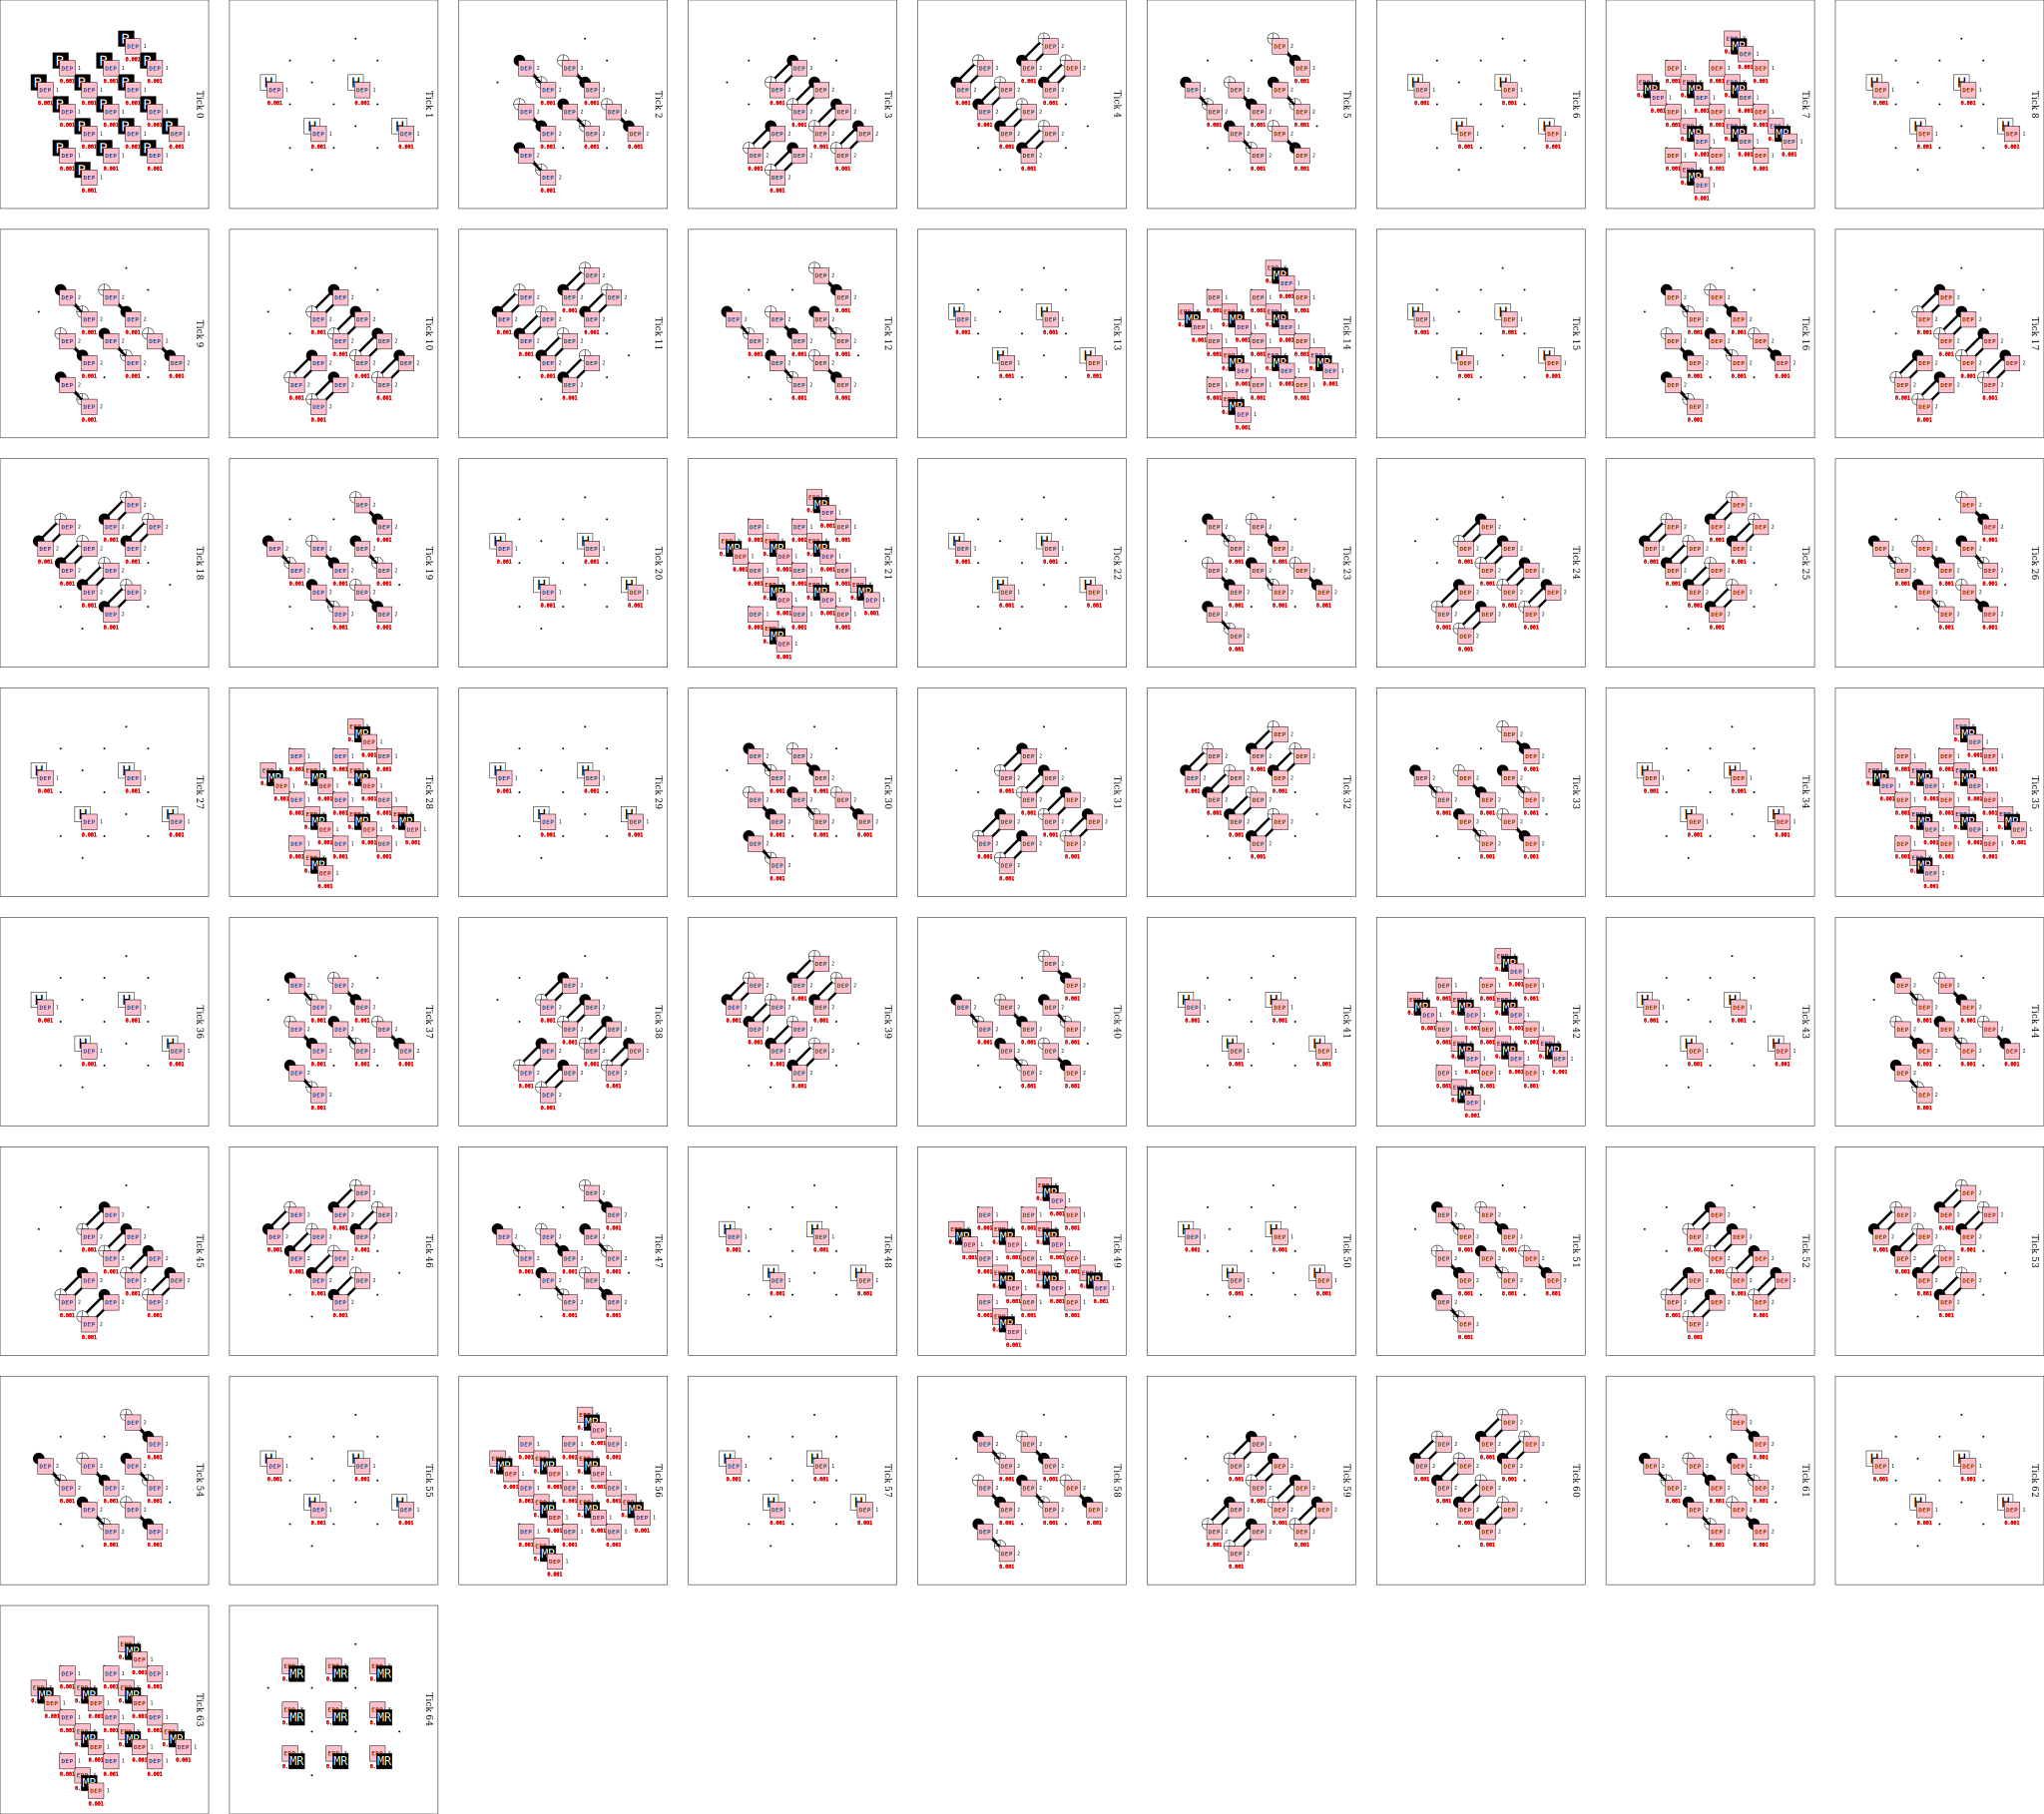

In [3]:
m, n = 3, 3
circuit = full_surface(m, n, 0.001, 9)
circuit.diagram('timeslice-svg')

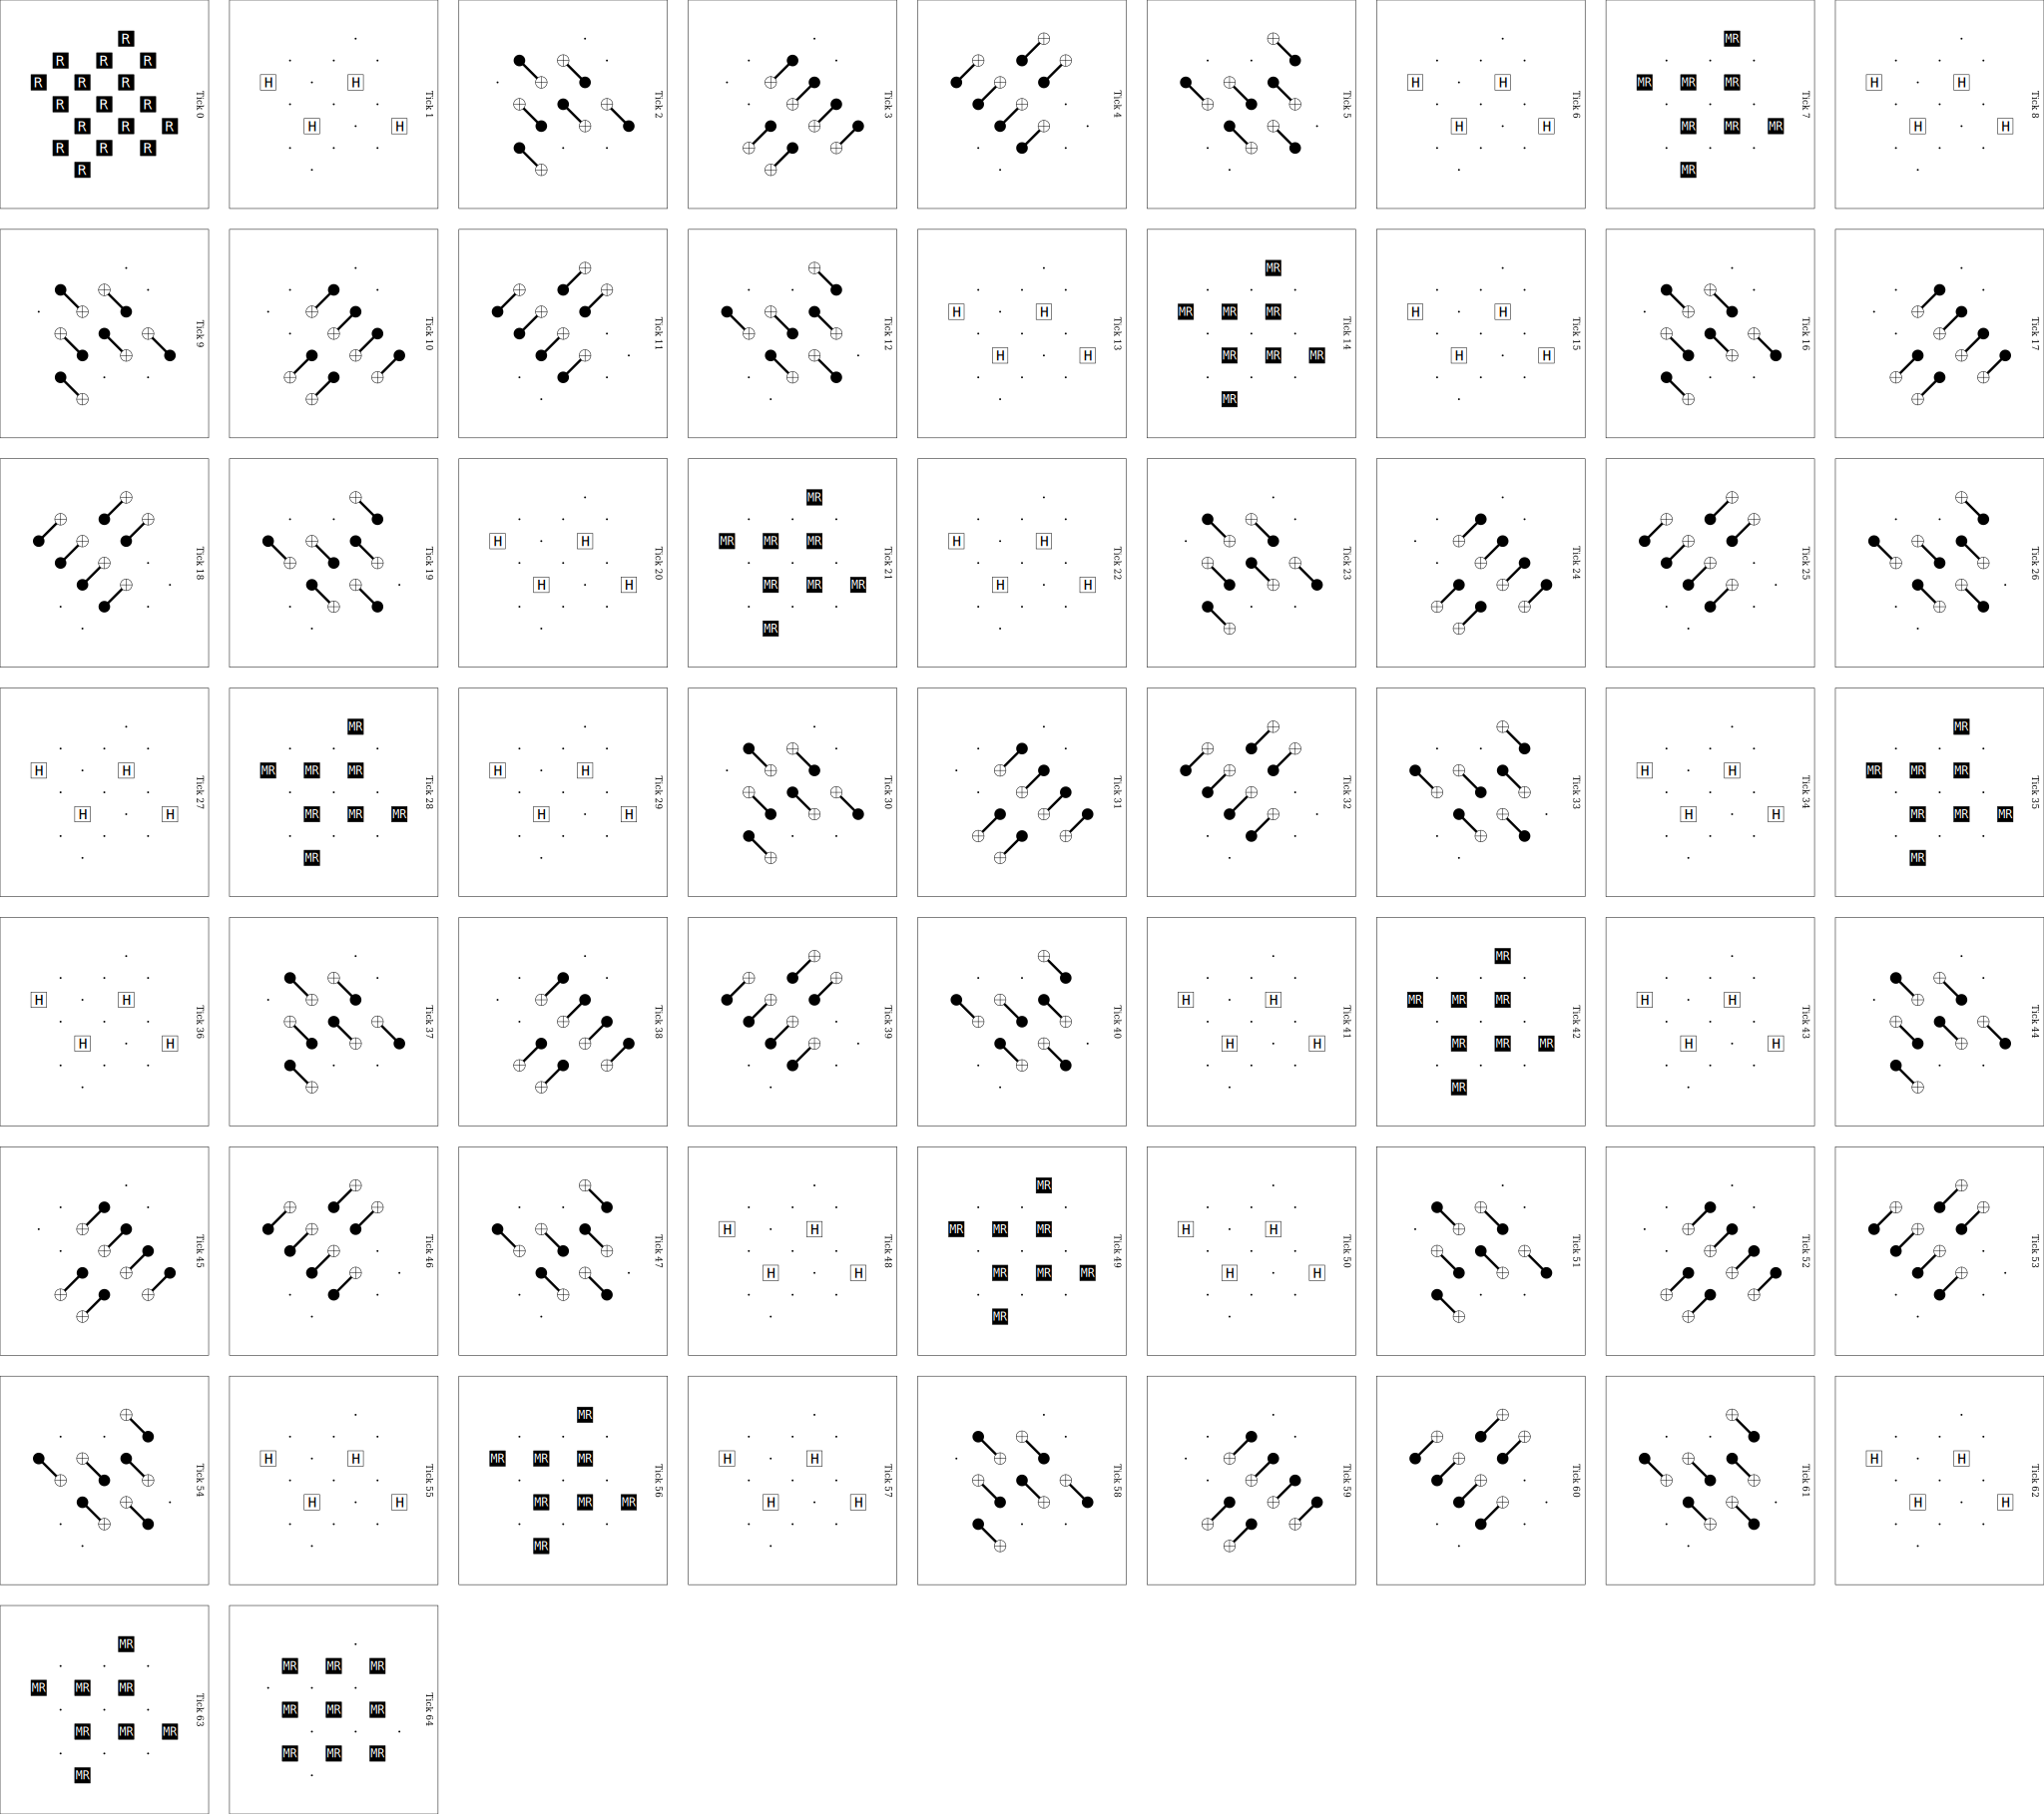

In [4]:
circuit.without_noise().diagram('timeslice-svg')

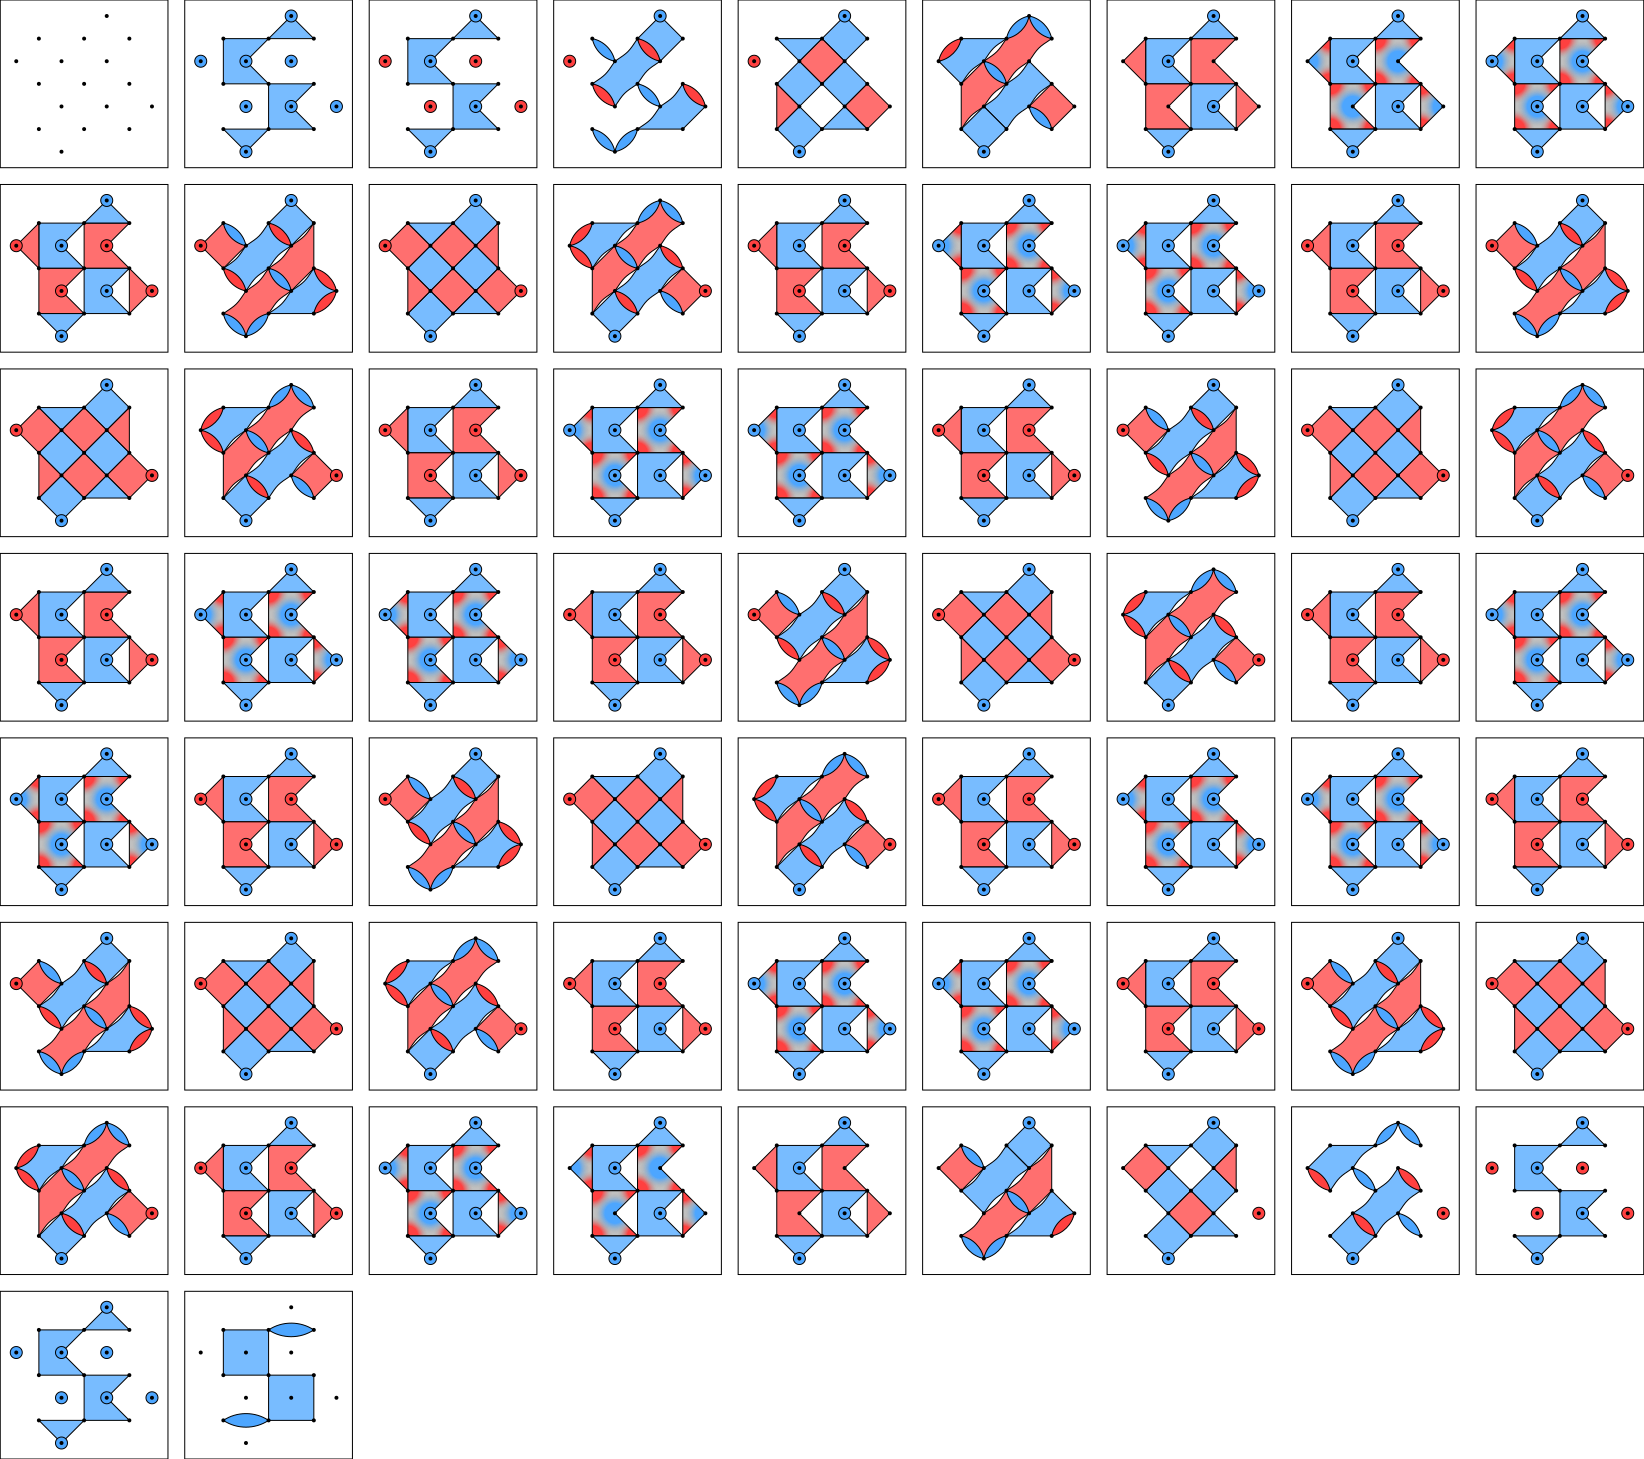

In [5]:
circuit.diagram('detslice-svg')

In [6]:
circuit.diagram('matchgraph-3d')

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":3,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":4,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":5,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":6,"byteOffset":0,"componentType":5126,"count":3814,"max":[16.5453414916992,10.2735033035278,36.8787841796875],"min":[-10.5453414916992,-10.5453414916992,-9.87878322601318],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":7,"byteOffset":0,"componentType":5126,"count":706,"max":[1.5,16.5453414916992,36.8787841796875],"min":[-4.27350330352783,-4.27350330352783,-9.87878322601318],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":1,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":2,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":3,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":4,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":5,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":6,"byteLength":45768,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":7,"byteLength":8472,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":45768,"name":"buf_scattered_lines","uri":"data:application/octet-stream;base64,AADAPwAAwD8AAAAAAACQQAAAkEAAAAAAAADAPwAAwD8AAAAAAACQQAAAwL8AAAAAAADAPwAAwD8AAAAAAACQQAAAwL8AAAAAAACQQAAAwD8AAEBAGM+8QAA6zD2qqdnAAADAPwAAwD8AAAAAAADAPwAAwD8AAEBAAADAPwAAwD8AAAAAAADAPwAAwD

In [7]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

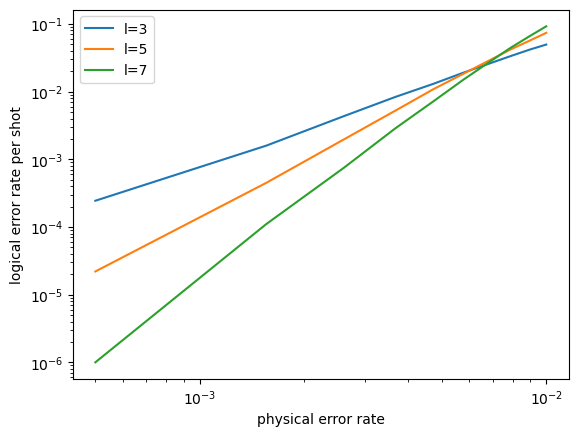

In [139]:
num_shots = 1_000_000
error_rates = np.linspace(0.0005, 0.01, 10)
for d in [3, 5, 7]:
    xs = []
    ys = []
    for noise in error_rates:
        circuit = full_surface(d, d, noise, d)
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        xs.append(noise)
        ys.append(num_errors_sampled / num_shots)
    plt.plot(xs, ys, label="l=" + str(d))
plt.loglog()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.legend()
plt.show()

In [10]:
tasks = [
    sinter.Task(
        circuit = full_surface(d, d, noise, d),
        json_metadata={'d': d, 'noise': noise}
    )
    for d in [3, 5, 7]
    for noise in np.linspace(0.001, 0.01, 10)
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=16,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=5000,
)

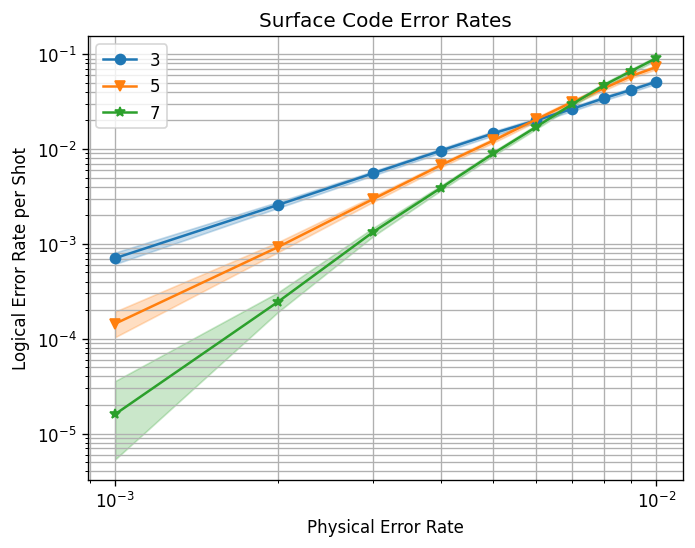

In [11]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['noise'],
    group_func=lambda stats: stats.json_metadata['d'],
)
# ax.set_ylim(1e-6, 5e-1)
# ax.set_xlim(5e-4, 1e-2)
ax.loglog()
ax.set_title("Surface Code Error Rates")
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

In [47]:
# Here we test how logical error rate grow with time
# A linear growth is expected

tasks = [
    sinter.Task(
        circuit = full_surface(d, d, 0.001, r),
        json_metadata={'r': r, 'd': d}
    )
    for r in range(1, 30, 2)
    for d in range(3, 10, 2)
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=16,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=10_000_000,
    max_errors=5000,
)

In [48]:
import pickle
import time

# store collected_stats to file
filename = f"ler_surface_{int(time.time())}.pkl"
with open(filename, "wb") as f:
    pickle.dump(collected_stats, f)

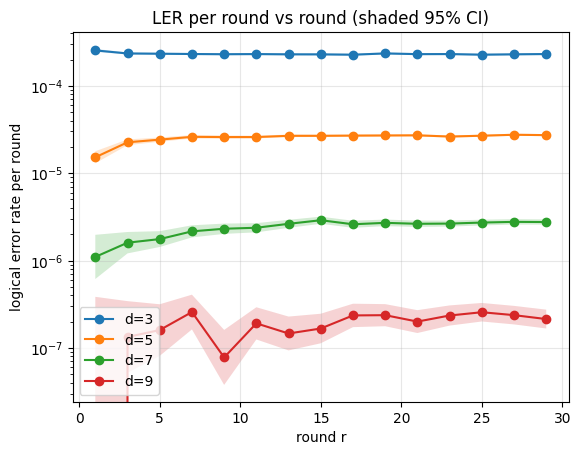

In [49]:
import math
import matplotlib.pyplot as plt

def _wilson_interval(e, n, z=1.96):
    if n <= 0:
        return 0.0, 0.0
    p = e / n
    denom = 1 + z*z/n
    center = (p + z*z/(2*n)) / denom
    half = (z * math.sqrt(p*(1 - p)/n + z*z/(4*n*n))) / denom
    lo = max(0.0, center - half)
    hi = min(1.0, center + half)
    return lo, hi

def plot_ler_per_round_vs_round_shaded(collected_stats, ci=0.95, alpha=0.2):
    # z for CI
    z = {0.80: 1.282, 0.90: 1.645, 0.95: 1.960, 0.98: 2.326, 0.99: 2.576}.get(ci, 1.960)

    # Aggregate by (d, r)
    agg = {}  # (d, r) -> [errors, accepted_shots]
    for s in collected_stats:
        md = getattr(s, 'json_metadata', {}) or {}
        d = int(md['d']); r = int(md['r'])
        shots = int(s.shots)
        discards = int(getattr(s, 'discards', 0))
        acc = shots - discards
        if acc <= 0:
            continue
        e = int(s.errors)
        agg.setdefault((d, r), [0, 0])
        agg[(d, r)][0] += e
        agg[(d, r)][1] += acc

    # Prepare per-distance series
    per_d = {}
    for (d, r), (e, n) in agg.items():
        p_shot = e / n
        # Per-round conversion: (1 - p_shot) = (1 - p_round)^r
        p_round = 1.0 - (1.0 - p_shot) ** (1.0 / r)
        lo_s, hi_s = _wilson_interval(e, n, z=z)
        lo_r = 1.0 - (1.0 - lo_s) ** (1.0 / r)
        hi_r = 1.0 - (1.0 - hi_s) ** (1.0 / r)
        per_d.setdefault(d, []).append((r, p_round, lo_r, hi_r))

    fig, ax = plt.subplots()
    for d in sorted(per_d.keys()):
        pts = sorted(per_d[d], key=lambda t: t[0])
        xs = [r for r, _, _, _ in pts]
        ys = [p for _, p, _, _ in pts]
        y_lower = [lo for _, _, lo, _ in pts]
        y_upper = [hi for _, _, _, hi in pts]

        # Mean curve
        ax.plot(xs, ys, marker='o', label=f'd={d}')
        # Shaded CI band
        ax.fill_between(xs, y_lower, y_upper, alpha=alpha)

    ax.set_xlabel('round r')
    ax.set_ylabel('logical error rate per round')
    ax.set_title(f'LER per round vs round (shaded {int(ci*100)}% CI)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    # Optional:
    ax.set_yscale('log')
    plt.show()

# Usage:
plot_ler_per_round_vs_round_shaded(collected_stats)


The result above indicates that simulating the first $d$ rounds gives you a good result of logical error rate per $d$ round.